# 급하지 말고 천천히 해보자

the different ways to use the MTCNN face detection module of facenet-pytorch

## Facenet vgg2 다운

In [3]:
!pip install facenet-pytorch
#import facenet-pytorch and instantiate models:
from facenet_pytorch import MTCNN, InceptionResnetV1
# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()
#pretrained models were trained on 160x160 px image
!pip install mmcv


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 24.4 MB/s 


  0%|          | 0.00/107M [00:00<?, ?B/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 28.2 MB/s 
     |████████████████████████████████| 190 kB 65.7 MB/s 
  Created wheel for mmcv: filename=mmcv-1.6.2-py2.py3-none-any.whl size=880266 sha256=063ede31077171840606026135e60ad00349c0ef874bf7f57b8ed4dedaeb53e5
  Stored in directory: /root/.cache/pip/wheels/bf/90/bc/c3251072082e6116fadbb9150b5645487bc2c6a3503c8e1b6c
Successfully built mmcv


In [8]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

### GPU 연결하기

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


Google drive연결

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


mtcnn : return torch tensors containing the detected face(s), rather than just the bounding boxes

## 비디오를 가져오기

torch.Size([3, 160, 160])

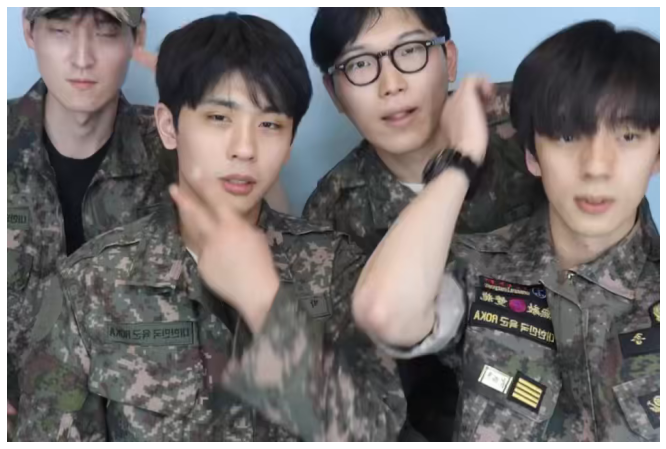

In [25]:
# Create face detector
mtcnn = MTCNN(select_largest=False, device='cuda') #cuda에 모델을 올리고

# Load a single image and display
#코렙은 서버여서 웹캠을 켤 수 없다
#try:
#    v_cap = cv2.VideoCapture(0)  # 카메라 켜기  # 카메라 캡쳐 (사진만 가져옴)
#except:
#    print('cannot load camera!')
video_path = "/content/gdrive/My Drive/FaceDetection/test.mp4"
v_cap = cv2.VideoCapture(video_path) #읽어드리기
success, frame = v_cap.read() #return 읽었냐?, 어떤걸
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame) #frame -> array

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

# Detect face
face = mtcnn(frame)
face.shape

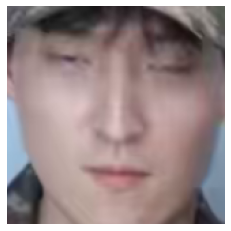

In [26]:
# Create face detector
mtcnn = MTCNN(select_largest=False, post_process=False, device='cuda:0')
#select_marge=False를 설정하여 검출된 얼굴이 크기가 아닌 검출 확률에 따라 정렬

# Detect face
face = mtcnn(frame)

# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');

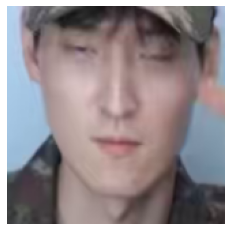

In [33]:
# Create face detector
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False, device='cuda:0') #사람이 보기 위해서는 post_process를 꺼야한다

# Detect face
face = mtcnn(frame)

# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
#numpy에서 이미지를 출력하고자 할 때 사용하는 permute를 사용
plt.axis('off');

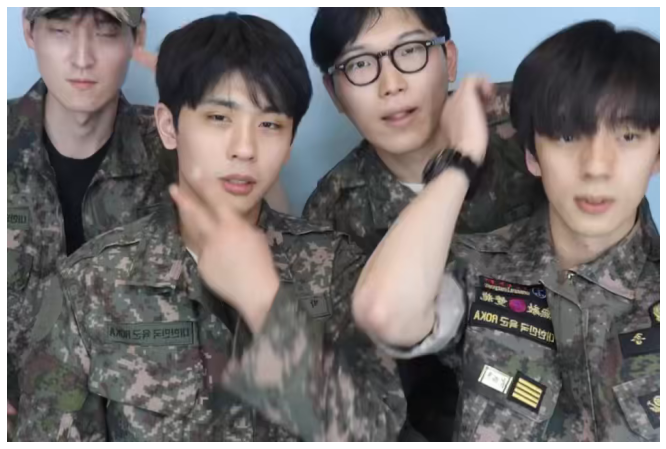

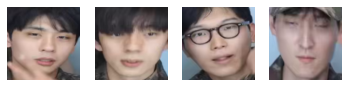

In [34]:
# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')
#margin: 여백을 얼만큼 줄 것이냐

# Load a single image and display
v_cap = cv2.VideoCapture(video_path)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

# Detect face
faces = mtcnn(frame)

# Visualize
fig, axes = plt.subplots(1, len(faces)) #얼굴이 인식되는 대로 뽑아내라
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()

위에는 얼굴을 하나씩 가져옴 -> 밑에는 여러개를 가져오려 함

  0%|          | 0/151 [00:00<?, ?it/s]

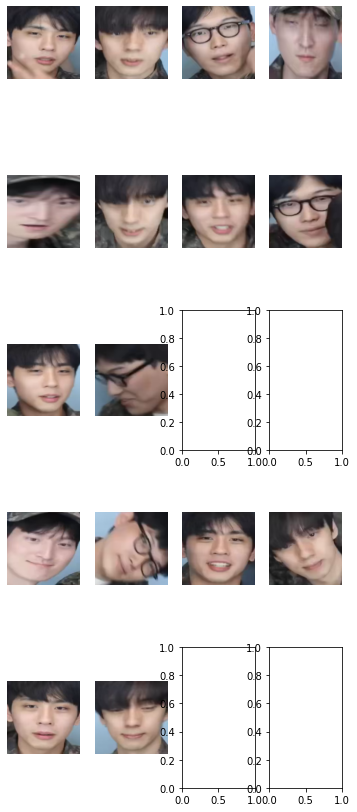

In [46]:
# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')

# Load a video
v_cap = cv2.VideoCapture(video_path)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
#cv2.CAP_PROP_FRAME_COUNT : 동영상 내의 프레임 수

# Loop through video, taking a handful of frames to form a batch
frames = []
for i in tqdm(range(v_len)):
    
    # Load frame
    success = v_cap.grab()
    if i % 30 == 0: # 30프레임이 지날때 마다 캡쳐
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #캡쳐 frame을 rgb로 가져옴
    frames.append(Image.fromarray(frame)) #array로 변환 mtcnn에 대입하려고

# Detect faces in batch
faces = mtcnn(frames)

fig, axes = plt.subplots(len(faces), 4, figsize=(6, 15))
for i, frame_faces in enumerate(faces):
    for j, face in enumerate(frame_faces):
        axes[i, j].imshow(face.permute(1, 2, 0).int().numpy())
        axes[i, j].axis('off')
fig.show()

### Frame 당 사람이 몇명 인식 되었는지 

  0%|          | 0/151 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

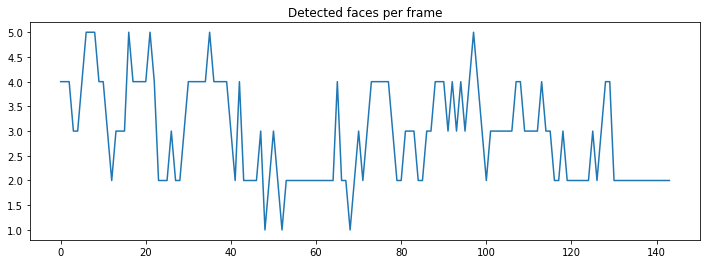

In [44]:
# Load a video
v_cap = cv2.VideoCapture(video_path)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through video
batch_size = 16
frames = []
faces = []
for _ in tqdm(range(v_len)):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        faces.extend(mtcnn(frames))
        frames = []

plt.figure(figsize=(12, 4))
plt.plot([len(f) for f in faces])
plt.title('Detected faces per frame');

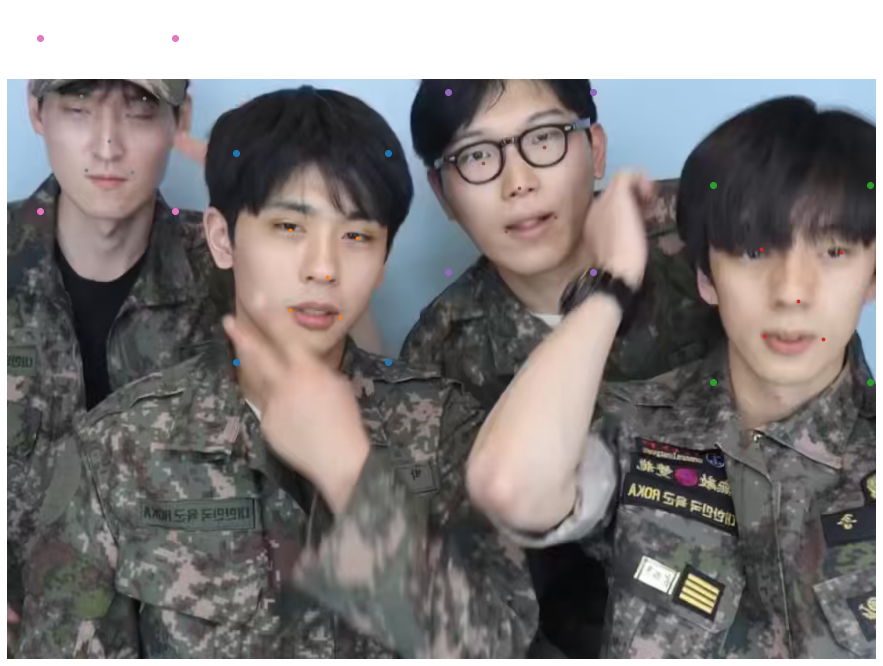

In [94]:
import matplotlib.patches as patches
# Create face detector
mtcnn = MTCNN(keep_all=True, device='cuda:0')

# Load a single image and display
v_cap = cv2.VideoCapture(video_path)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    #print(box)
    #print(box[[0, 2]], box[[1, 3]])
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

  0%|          | 0/151 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

9


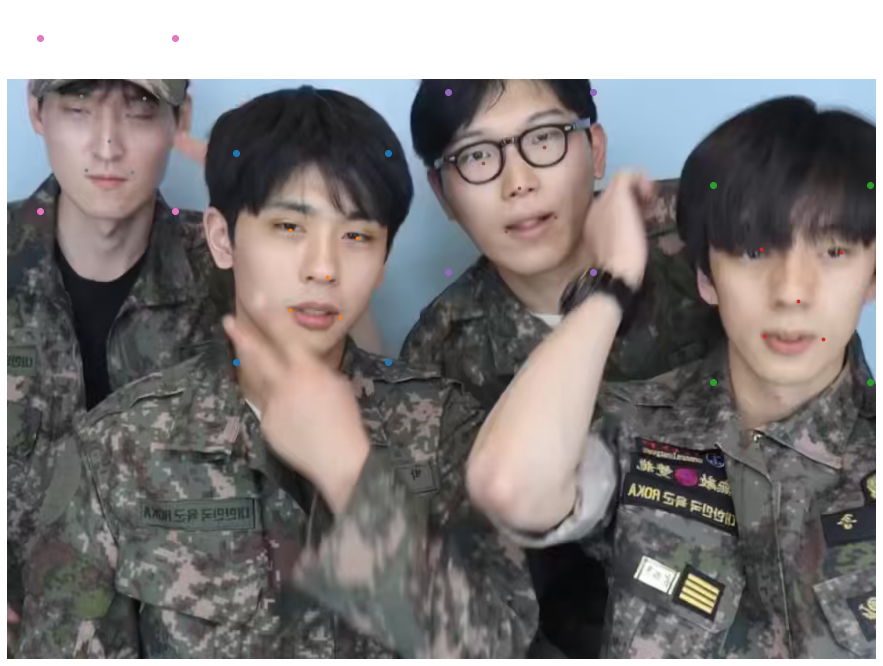

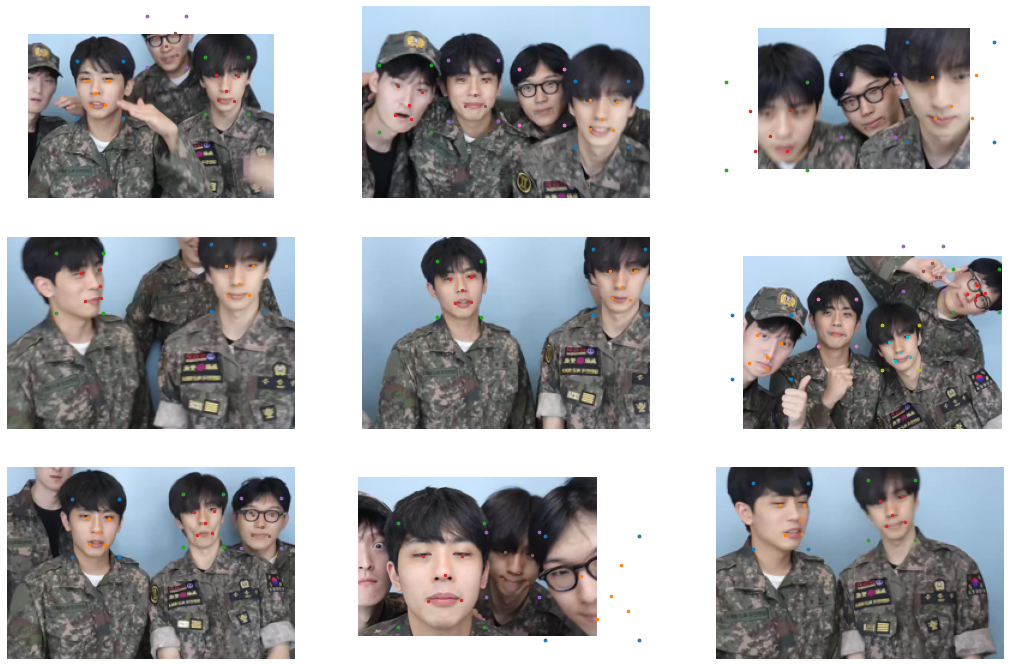

In [117]:
# Create face detector
mtcnn = MTCNN(keep_all=True, device='cuda:0') #모을 수 있게 keep_all True

# Load a single image and display
v_cap = cv2.VideoCapture(video_path)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True) #.detect() method will always return all detected bounding boxes (and optional landmarks) in an image.

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()
#The following example demonstrates how to show bounding boxes and facial landmarks in every frame in a video.

# Load a video
v_cap = cv2.VideoCapture(video_path)

# Loop through video
batch_size = 16
frames = []
boxes = []
landmarks = []
view_frames = []
view_boxes = []
view_landmarks = []
for _ in tqdm(range(v_len)):
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch, resizing for speed
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.resize([int(f * 0.25) for f in frame.size])
    frames.append(frame)
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        batch_boxes, _, batch_landmarks = mtcnn.detect(frames, landmarks=True)
        boxes.extend(batch_boxes)
        landmarks.extend(batch_landmarks)
        
        view_frames.append(frames[-1])
        view_boxes.append(boxes[-1])
        view_landmarks.append(landmarks[-1])
        
        frames = []

# Visualize
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
print(len(view_frames))
for i in range(len(view_frames)):
    ax[int(i / 3), i % 3].imshow(view_frames[i])
    ax[int(i / 3), i % 3].axis('off')
    for box, landmark in zip(view_boxes[i], view_landmarks[i]):
        ax[int(i / 3), i % 3].scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]), s=8)
        ax[int(i / 3), i % 3].scatter(landmark[:, 0], landmark[:, 1], s=6)

## 저장하기

In [121]:
print(len(frames))

6


In [122]:
# Batch
save_paths = [f'image_{i}.jpg' for i in range(len(frames))]
mtcnn(frames, save_path=save_paths);

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd